##***Exploratory Data Analysis : Advanced Feature Extraction.***

In [ ]:
#importing all the relevant modules
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install distance

In [ ]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
#importing the manually installed packages
import distance
from fuzzywuzzy import fuzz

In [ ]:
#loading the data set using drive function of google colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/My\ Drive/Colab Notebooks

In [ ]:
#uploading DataFrame that we created in previous notebook
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("Get table df_fe_without_preprocessing_train.csv from drive or run the notebook 1")

In [ ]:
#publishing top few rows of the table
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


###***Preprocessing of Text***

***Preprocessing :***



1.   __Removing html tags__
2.   __Removing Punctuations__
3.   __Performing stemming__
4.   __Removing Stopwords__
5.   __Expanding contractions etc.__

In [ ]:
#defining function to preprocess the string data in questions
SAFE_DIV   = 0.0001 
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)    
    porter  = PorterStemmer()
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    return x

###***Advanced Feature Extraction using NLP techniques and Fuzzy Features***

***Definition :***


1.   __Token : You get a token by splitting sentence a space__
2.   __Stop Word : stop words as per NLTK__
3.   __Word : A token that is not a stop_word__

***Features :***


- __cwc_min :__ Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
- __cwc_max :__ Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- __csc_min :__ Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br>csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- __csc_max :__ Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 <br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
- __ctc_min :__ Ratio of common_token_count to min lenghth of token count of Q1 and Q2 <br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- __ctc_max :__ Ratio of common_token_count to max lenghth of token count of Q1 and Q2 <br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- __last_word_eq :__ Check if First word of both questions is equal or not <br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- __first_word_eq :__ Check if First word of both questions is equal or not <br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
- __abs_len_diff :__ Abs. length difference <br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
- __mean_len :__ Average Token Length of both Questions <br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
- __longest_substr_ratio :__ Ratio of length longest common substring to min lenghth of token count of Q1 and Q2 <br>
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

***Features from NLP function :***


- __fuzz_ratio :__<br> https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __fuzz_partial_ratio :__<br> https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_sort_ratio :__<br> https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_set_ratio :__<br> https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


In [ ]:
#defining functions as described above
def get_token_features(q1, q2):
    token_features = [0.0]*10
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    #Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stopwords])
    q2_words = set([word for word in q2_tokens if word not in stopwords])   
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stopwords])
    q2_stops = set([word for word in q2_tokens if word in stopwords])
    #Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))    
    #Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    #Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    #now creating the advanced features as defined above
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    #Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    #First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    #absolute length difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0])/(min(len(a),len(b))+1)

def extract_features(df):
    #preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    print("Token Features Ongoing...")
    # Merging Features with dataset    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    #Computing Fuzzy Features and Merging with Dataset
    print("Fuzzy Features Ongoing...")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
#Transforming the data into trainable data using above defined feature definitions
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting Features to Train")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)

Extracting Features to Train
Token Features Ongoing...
Fuzzy Features Ongoing...


In [ ]:
#publishing top few rows from the updated processed Data
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667


###***Analysis of extracted features***

***Plotting Word clouds :***

1.   __Creating Word Cloud of Duplicates and Non-Duplicates Question pairs__
2.   __We can observe the most frequent occuring words__


In [ ]:
#Segregating the data set based on the class label
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

In [ ]:
#Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()
print ("Number of data points in class 1 (duplicate pairs)     :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs)     : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')
textp_w    = open(path.join(d, 'train_p.txt')).read()
textn_w    = open(path.join(d, 'train_n.txt')).read()
stopwords  = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
print("Total number of words in duplicate pair questions     :",len(textp_w))
print("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions     : 16110090
Total number of words in non duplicate pair questions : 33211109


***Word Cloud generated from Words of Duplicate pair of questions***


Word Cloud for Duplicate Question pairs


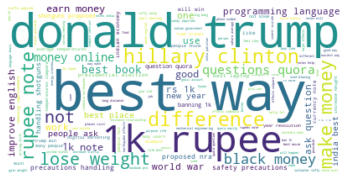

In [ ]:
#Publishing the word cloud for all the words present in the pair of questions that are duplicate
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

***Word Cloud generated from Words of Non Duplicate pair of questions***


Word Cloud for non-Duplicate Question pairs:


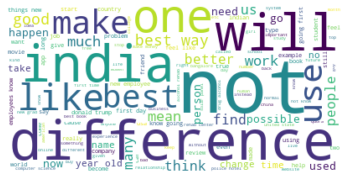

In [ ]:
#Publishing the word cloud for all the words present in the pair of questions that are not duplicate
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

***Pair plot of features :***

1.   __ctc_min__
2.   __cwc_min__
3.   __csc_min__
4.   __token_sort_ratio__


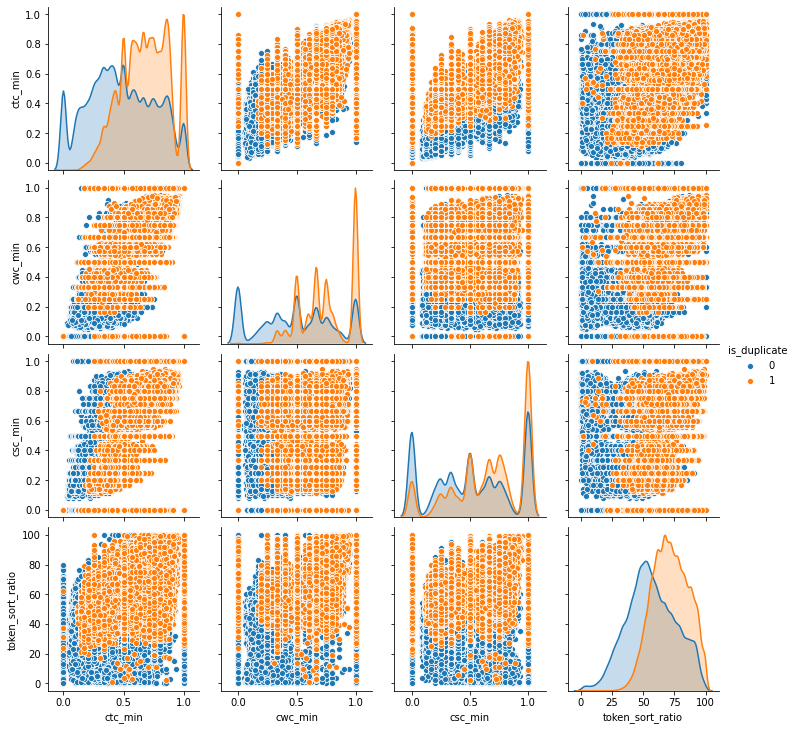

In [ ]:
#ploting the pair plot
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

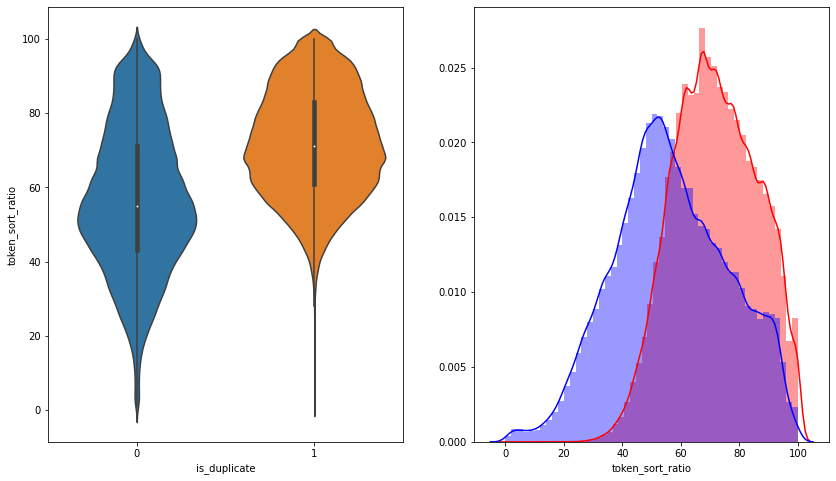

In [ ]:
#Distribution of the token_sort_ratio
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio',data=df[0:],)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

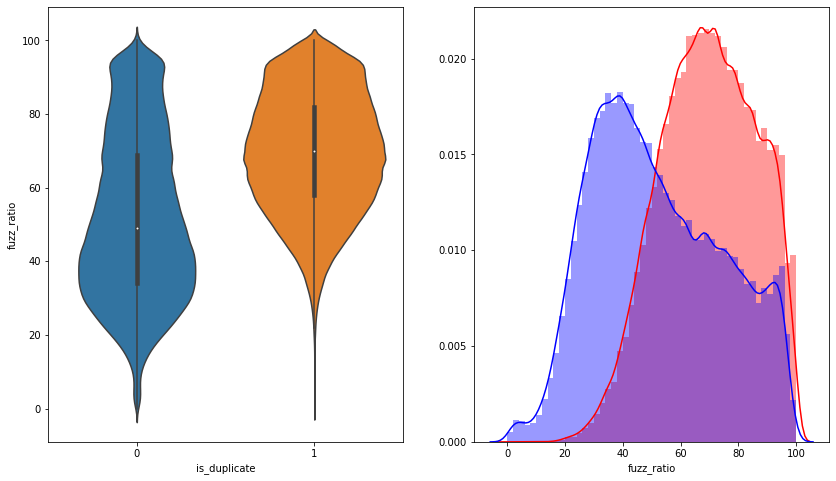

In [ ]:
#Distribution of the fuzz_ratio
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio',data = df[0:],)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

###***Visualization***

In [ ]:
#Using TSNE for Dimentionality reduction for 15 Features that are generated after cleaning the data to 3 dimension
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
#defining the TSNE to fit and transform
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.048s...
[t-SNE] Computed neighbors for 10000 samples in 1.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.107267
[t-SNE] Computed conditional probabilities in 0.639s
[t-SNE] Iteration 50: error = 96.0124359, gradient norm = 0.0219437 (50 iterations in 5.490s)
[t-SNE] It

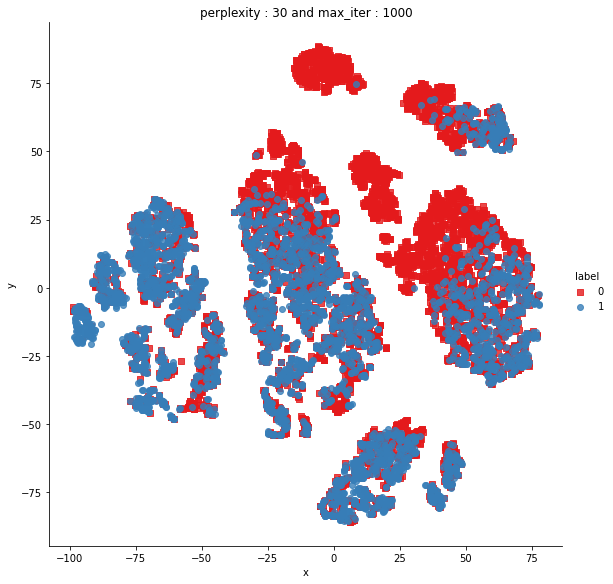

In [ ]:
#draw the plot in appropriate place in the grid with 2 component 
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

***Observation :***


1.   __Using our personalized feature enginerring on the Data set we got 15 features and via TSNE we can see, to an extent data is seperable using these features. As TSNE is an algorithm with high time complexity that is O(N*N), we have only taken a very small subset of points for the visualization.__

###***-- End of Notebook 2 --***